In [228]:
import yfinance as yf
import pandas as pd

ticker = 'AAPL'
start_date = '2019-01-01'
end_date = '2024-12-31'

aapl_data = yf.download(ticker, start=start_date, end=end_date)
aapl_prices = aapl_data[['Close', 'Adj Close']]
aapl_prices.to_csv('aapl_prices.csv')

print(f"AAPL close and adjusted close price data from {start_date} to {end_date} saved to aapl_prices.csv")


[*********************100%%**********************]  1 of 1 completed

AAPL close and adjusted close price data from 2019-01-01 to 2024-12-31 saved to aapl_prices.csv


In [229]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [230]:
calls = df[df['call_put'] == 'Call'].copy()
puts = df[df['call_put'] == 'Put'].copy()

calls.drop(columns=['call_put'], inplace=True)
puts.drop(columns=['call_put'], inplace=True)

calls.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_call' for col in calls.columns[4:]]
puts.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_put' for col in puts.columns[4:]]

merged_df = pd.merge(calls, puts, on=['date', 'act_symbol', 'expiration', 'strike'], how='outer')

In [231]:
def preprocess_data(aapl_close, aapl_straddle_data):
    aapl_close['date'] = pd.to_datetime(aapl_close['date'])
    aapl_straddle_data['date'] = pd.to_datetime(aapl_straddle_data['date'])
    aapl_straddle_data['expiration'] = pd.to_datetime(aapl_straddle_data['expiration'])
    aapl_close = aapl_close.sort_values(by='date')
    aapl_straddle_data = aapl_straddle_data.sort_values(by=['date', 'expiration'])
    return aapl_close, aapl_straddle_data

In [232]:
def add_close_prices(aapl_prices, aapl_straddle_data):
    aapl_straddle_data = aapl_straddle_data.sort_values(by='date')
    aapl_straddle_data = pd.merge_asof(aapl_straddle_data, aapl_prices[['date', 'Close']], 
                                       left_on='date', right_on='date', direction='backward')
    aapl_straddle_data.rename(columns={'Close': 'current_close'}, inplace=True)
    aapl_straddle_data = aapl_straddle_data.sort_values(by='expiration')
    aapl_straddle_data = pd.merge_asof(aapl_straddle_data, aapl_prices[['date', 'Close']], 
                                       left_on='expiration', right_on='date', direction='backward')
    aapl_straddle_data.rename(columns={'Close': 'expiration_close'}, inplace=True)
    aapl_straddle_data.drop(columns=['date_y'], inplace=True)
    aapl_straddle_data.rename(columns={'date_x': 'date'}, inplace=True)
    return aapl_straddle_data

In [233]:
def calculate_straddle_prices(aapl_straddle_data):
    aapl_straddle_data['mid_call'] = (aapl_straddle_data['bid_call'] + aapl_straddle_data['ask_call']) / 2
    aapl_straddle_data['mid_put'] = (aapl_straddle_data['bid_put'] + aapl_straddle_data['ask_put']) / 2
    aapl_straddle_data['straddle_price'] = aapl_straddle_data['mid_call'] + aapl_straddle_data['mid_put']
    aapl_straddle_data['straddle_delta'] = aapl_straddle_data['delta_call'] + aapl_straddle_data['delta_put']
    return aapl_straddle_data

In [234]:
def calculate_delta_neutralized_returns(aapl_straddle_data):
    results = []
    for _, row in aapl_straddle_data.iterrows():
        initial_straddle_price = row['straddle_price']
        initial_delta = row['straddle_delta']
        initial_underlying_price = row['current_close']
        final_underlying_price = row['expiration_close']
        strike_price = row['strike']
        intrinsic_value_call = max(0, final_underlying_price - strike_price)
        intrinsic_value_put = max(0, strike_price - final_underlying_price)
        final_straddle_payoff = intrinsic_value_call + intrinsic_value_put
        underlying_price_change = final_underlying_price - initial_underlying_price
        delta_neutralized_return = (
            (final_straddle_payoff - initial_straddle_price)
            - (initial_delta * underlying_price_change)
        ) / initial_straddle_price
        results.append(delta_neutralized_return)
    aapl_straddle_data['delta_neutral_long_straddle_returns'] = results
    return aapl_straddle_data

In [237]:
# aapl_prices_path = 'aapl_prices.csv'
# aapl_prices = pd.read_csv(aapl_prices_path)

import pandas as pd

# Load AAPL prices data
aapl_prices_path = 'aapl_prices.csv'
aapl_prices = pd.read_csv(aapl_prices_path)

# Print the column names to inspect them
print(aapl_prices.columns)


# Preprocess data
aapl_prices, merged_df = preprocess_data(aapl_prices, merged_df)
merged_df = add_close_prices(aapl_prices, merged_df)
merged_df = calculate_straddle_prices(merged_df)
merged_df = calculate_delta_neutralized_returns(merged_df)

Index(['Date', 'Close', 'Adj Close'], dtype='object')


KeyError: 'date'

In [205]:
vol_df['date'] = pd.to_datetime(vol_df['date'])
merged_df = pd.merge(merged_df, vol_df, on='date', how='left')

merged_df.drop(columns=['act_symbol_y'], inplace=True)
merged_df.rename(columns={'act_symbol_x': 'act_symbol'}, inplace=True)

In [211]:
output_path = 'aapl_final_straddle_data.csv'
merged_df.to_csv(output_path, index=False)
cols = [col for col in merged_df.columns if col != 'delta_neutral_long_straddle_returns']
cols.append('delta_neutral_long_straddle_returns')
merged_df = merged_df[cols]
merged_df.head(100)

/Users/matthewbellick/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py:7833: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,date,act_symbol,expiration,strike,bid_call,ask_call,vol_call,delta_call,gamma_call,theta_call,vega_call,rho_call,bid_put,ask_put,vol_put,delta_put,gamma_put,theta_put,vega_put,rho_put,current_adj_close,expiration_adj_close,mid_call,mid_put,straddle_price,straddle_delta,hv_current,hv_week_ago,hv_month_ago,hv_year_high,hv_year_high_date,hv_year_low,hv_year_low_date,iv_current,iv_week_ago,iv_month_ago,iv_year_high,iv_year_high_date,iv_year_low,iv_year_low_date,delta_neutral_long_straddle_returns
0,2019-02-09,AAPL,2019-02-22,145.0,25.30,26.05,0.4236,0.9773,0.0038,-0.0371,0.0180,0.0540,0.06,0.08,0.3886,-0.0149,0.0029,-0.0172,0.0125,-0.0010,40.957829,41.573120,25.675,0.070,25.745,0.9624,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,2.994357
1,2019-02-09,AAPL,2019-02-22,195.0,0.02,0.05,0.2818,0.0082,0.0024,-0.0077,0.0075,0.0005,24.35,24.95,0.3340,-0.9875,0.0051,-0.0093,0.0114,-0.0116,40.957829,41.573120,0.035,24.650,24.685,-0.9793,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,5.239799
2,2019-02-09,AAPL,2019-02-22,187.5,0.08,0.11,0.2529,0.0296,0.0080,-0.0207,0.0225,0.0019,16.95,17.45,0.2926,-0.9563,0.0115,-0.0265,0.0319,-0.0258,40.957829,41.573120,0.095,17.200,17.295,-0.9267,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,7.470487
3,2019-02-09,AAPL,2019-02-22,157.5,13.30,13.55,0.2950,0.9208,0.0150,-0.0619,0.0492,0.0550,0.26,0.29,0.2763,-0.0664,0.0140,-0.0417,0.0434,-0.0042,40.957829,41.573120,13.425,0.275,13.700,0.8544,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,7.423443
4,2019-02-09,AAPL,2019-02-22,177.5,0.68,0.71,0.2172,0.1803,0.0362,-0.0701,0.0876,0.0115,7.45,7.65,0.2050,-0.8422,0.0374,-0.0520,0.0828,-0.0356,40.957829,41.573120,0.695,7.550,8.245,-0.6619,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,15.535372
5,2019-02-09,AAPL,2019-02-22,175.0,1.22,1.26,0.2178,0.2812,0.0464,-0.0909,0.1125,0.0179,5.50,5.70,0.2099,-0.7317,0.0484,-0.0757,0.1097,-0.0364,40.957829,41.573120,1.240,5.600,6.840,-0.4505,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,18.547378
6,2019-02-09,AAPL,2019-02-22,170.0,3.25,3.35,0.2261,0.5393,0.0526,-0.1132,0.1324,0.0340,2.60,2.69,0.2191,-0.4621,0.0549,-0.0992,0.1326,-0.0266,40.957829,41.573120,3.300,2.645,5.945,0.0772,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,20.594513
7,2019-02-09,AAPL,2019-02-22,167.5,4.80,4.95,0.2350,0.6623,0.0466,-0.1099,0.1219,0.0414,1.68,1.73,0.2265,-0.3337,0.0485,-0.0950,0.1232,-0.0199,40.957829,41.573120,4.875,1.705,6.580,0.3286,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,18.107097
8,2019-02-09,AAPL,2019-02-22,162.5,8.75,8.90,0.2582,0.8376,0.0285,-0.0850,0.0820,0.0513,0.64,0.67,0.2455,-0.1507,0.0287,-0.0670,0.0811,-0.0093,40.957829,41.573120,8.825,0.655,9.480,0.6869,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,11.711417
9,2019-02-09,AAPL,2019-02-22,152.5,17.90,18.55,0.3267,0.9627,0.0075,-0.0419,0.0271,0.0559,0.12,0.16,0.3166,-0.0330,0.0070,-0.0274,0.0246,-0.0022,40.957829,41.573120,18.225,0.140,18.365,0.9297,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25,5.008976


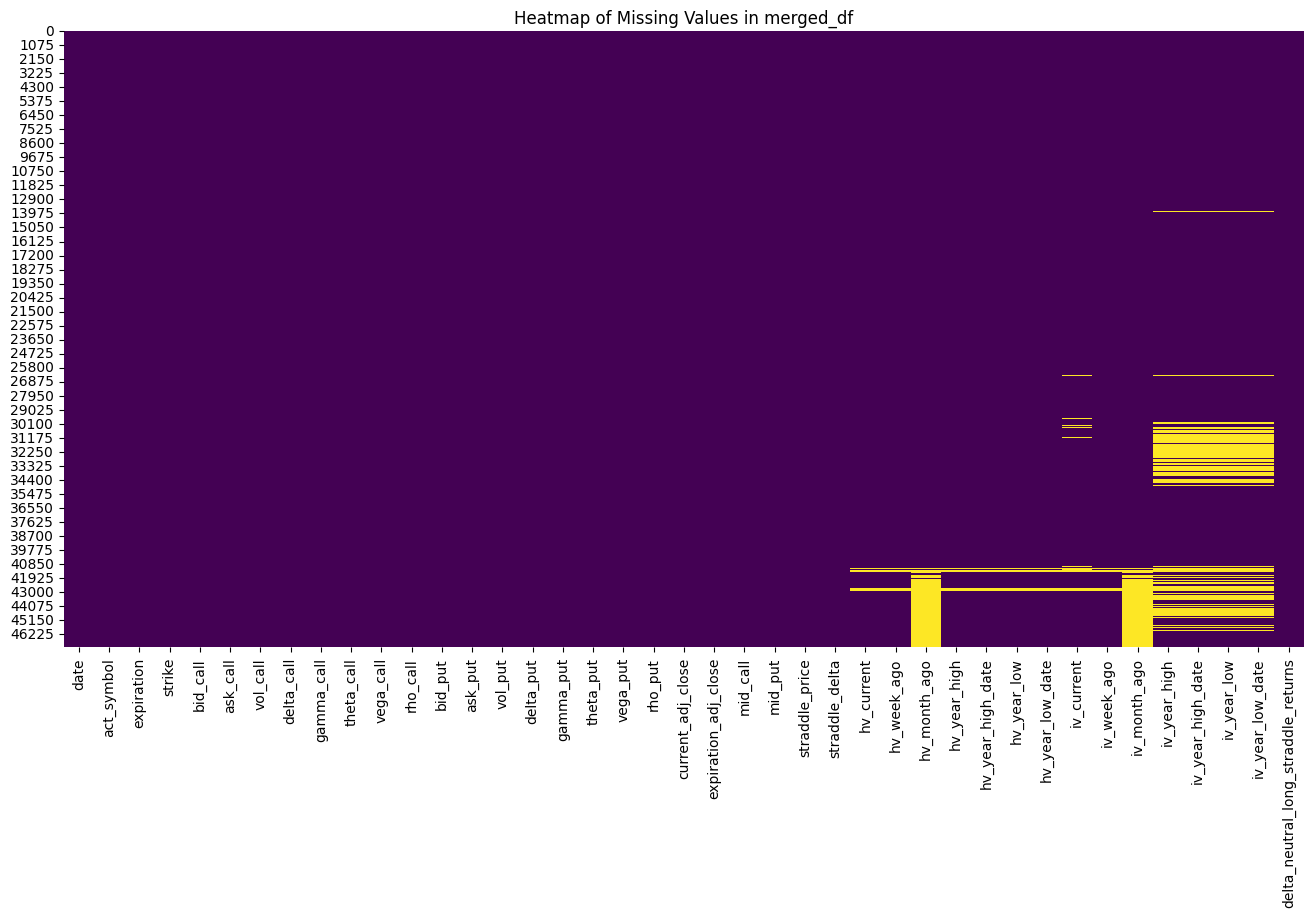

Number of NA values in each column:
date                                      0
act_symbol                                0
expiration                                0
strike                                    0
bid_call                                  0
ask_call                                  0
vol_call                                  0
delta_call                                0
gamma_call                                0
theta_call                                0
vega_call                                 0
rho_call                                  0
bid_put                                   0
ask_put                                   0
vol_put                                   0
delta_put                                 0
gamma_put                                 0
theta_put                                 0
vega_put                                  0
rho_put                                   0
current_adj_close                         0
expiration_adj_close                    

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(merged_df.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in merged_df')
plt.show()

na_counts = merged_df.isna().sum()
print("Number of NA values in each column:")
print(na_counts)

num_rows = merged_df.shape[0]
print("\nNumber of rows in merged_df:")
print(num_rows)

In [210]:
merged_df["delta_neutral_long_straddle_returns"].describe()

count    47279.000000
mean         0.925846
std          2.730004
min         -1.038525
25%         -0.091368
50%          0.007934
75%          0.161596
max         30.023859
Name: delta_neutral_long_straddle_returns, dtype: float64

In [242]:
import yfinance as yf
import pandas as pd

# Download AAPL data
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = '2024-12-31'

aapl_data = yf.download(ticker, start=start_date, end=end_date)
aapl_prices = aapl_data[['Close', 'Adj Close']]
aapl_prices.to_csv('aapl_prices.csv')

print(f"AAPL close and adjusted close price data from {start_date} to {end_date} saved to aapl_prices.csv")

# Assuming `df` is defined somewhere before this code
# This snippet is for separating calls and puts and merging them
calls = df[df['call_put'] == 'Call'].copy()
puts = df[df['call_put'] == 'Put'].copy()

calls.drop(columns=['call_put'], inplace=True)
puts.drop(columns=['call_put'], inplace=True)

calls.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_call' for col in calls.columns[4:]]
puts.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_put' for col in puts.columns[4:]]

merged_df = pd.merge(calls, puts, on=['date', 'act_symbol', 'expiration', 'strike'], how='outer')

# Load AAPL prices data and inspect columns
aapl_prices_path = 'aapl_prices.csv'
aapl_prices = pd.read_csv(aapl_prices_path)

# Print column names to check the date column
print(aapl_prices.columns)

# Define the preprocessing function
def preprocess_data(aapl_close, aapl_straddle_data):
    aapl_close['Date'] = pd.to_datetime(aapl_close['Date'])
    aapl_straddle_data['date'] = pd.to_datetime(aapl_straddle_data['date'])
    aapl_straddle_data['expiration'] = pd.to_datetime(aapl_straddle_data['expiration'])
    aapl_close = aapl_close.sort_values(by='Date')
    aapl_straddle_data = aapl_straddle_data.sort_values(by=['date', 'expiration'])
    return aapl_close, aapl_straddle_data

# Function to add close prices
def add_close_prices(aapl_prices, aapl_straddle_data):
    aapl_straddle_data = aapl_straddle_data.sort_values(by='date')
    aapl_straddle_data = pd.merge_asof(aapl_straddle_data, aapl_prices[['Date', 'Close']], 
                                       left_on='date', right_on='Date', direction='backward')
    aapl_straddle_data.rename(columns={'Close': 'current_close', 'Date': 'current_date'}, inplace=True)
    
    aapl_straddle_data = aapl_straddle_data.sort_values(by='expiration')
    aapl_straddle_data = pd.merge_asof(aapl_straddle_data, aapl_prices[['Date', 'Close']], 
                                       left_on='expiration', right_on='Date', direction='backward')
    aapl_straddle_data.rename(columns={'Close': 'expiration_close', 'Date': 'expiration_date'}, inplace=True)
    
    # Drop the duplicate date columns
    aapl_straddle_data.drop(columns=['current_date', 'expiration_date'], inplace=True)
    
    return aapl_straddle_data

# Function to calculate straddle prices
def calculate_straddle_prices(aapl_straddle_data):
    aapl_straddle_data['mid_call'] = (aapl_straddle_data['bid_call'] + aapl_straddle_data['ask_call']) / 2
    aapl_straddle_data['mid_put'] = (aapl_straddle_data['bid_put'] + aapl_straddle_data['ask_put']) / 2
    aapl_straddle_data['straddle_price'] = aapl_straddle_data['mid_call'] + aapl_straddle_data['mid_put']
    aapl_straddle_data['straddle_delta'] = aapl_straddle_data['delta_call'] + aapl_straddle_data['delta_put']
    return aapl_straddle_data

# Function to calculate delta neutralized returns
def calculate_delta_neutralized_returns(aapl_straddle_data):
    results = []
    for _, row in aapl_straddle_data.iterrows():
        initial_straddle_price = row['straddle_price']
        initial_delta = row['straddle_delta']
        initial_underlying_price = row['current_close']
        final_underlying_price = row['expiration_close']
        strike_price = row['strike']
        intrinsic_value_call = max(0, final_underlying_price - strike_price)
        intrinsic_value_put = max(0, strike_price - final_underlying_price)
        final_straddle_payoff = intrinsic_value_call + intrinsic_value_put
        underlying_price_change = final_underlying_price - initial_underlying_price
        delta_neutralized_return = (
            (final_straddle_payoff - initial_straddle_price)
            - (initial_delta * underlying_price_change)
        ) / initial_straddle_price
        results.append(delta_neutralized_return)
    aapl_straddle_data['delta_neutral_long_straddle_returns'] = results
    return aapl_straddle_data

# Preprocess data
aapl_prices, merged_df = preprocess_data(aapl_prices, merged_df)
merged_df = add_close_prices(aapl_prices, merged_df)
merged_df = calculate_straddle_prices(merged_df)
merged_df = calculate_delta_neutralized_returns(merged_df)

# Saving the final DataFrame to a CSV file
output_path = 'aapl_final_straddle_data.csv'
merged_df.to_csv(output_path, index=False)

# Reorder columns to place 'delta_neutral_long_straddle_returns' at the end
cols = [col for col in merged_df.columns if col != 'delta_neutral_long_straddle_returns']
cols.append('delta_neutral_long_straddle_returns')
merged_df = merged_df[cols]

# Display the first 100 rows of the DataFrame
merged_df.head(500)


[*********************100%%**********************]  1 of 1 completed


AAPL close and adjusted close price data from 2019-01-01 to 2024-12-31 saved to aapl_prices.csv
Index(['Date', 'Close', 'Adj Close'], dtype='object')


,date,act_symbol,expiration,strike,bid_call,ask_call,vol_call,delta_call,gamma_call,theta_call,vega_call,rho_call,bid_put,ask_put,vol_put,delta_put,gamma_put,theta_put,vega_put,rho_put,current_close,expiration_close,mid_call,mid_put,straddle_price,straddle_delta,delta_neutral_long_straddle_returns
0,2019-02-09,AAPL,2019-02-22,145.0,25.30,26.05,0.4236,0.9773,0.0038,-0.0371,0.0180,0.0540,0.06,0.08,0.3886,-0.0149,0.0029,-0.0172,0.0125,-0.0010,42.602501,43.242500,25.675,0.070,25.745,0.9624,2.928591
1,2019-02-09,AAPL,2019-02-22,195.0,0.02,0.05,0.2818,0.0082,0.0024,-0.0077,0.0075,0.0005,24.35,24.95,0.3340,-0.9875,0.0051,-0.0093,0.0114,-0.0116,42.602501,43.242500,0.035,24.650,24.685,-0.9793,5.173152
2,2019-02-09,AAPL,2019-02-22,187.5,0.08,0.11,0.2529,0.0296,0.0080,-0.0207,0.0225,0.0019,16.95,17.45,0.2926,-0.9563,0.0115,-0.0265,0.0319,-0.0258,42.602501,43.242500,0.095,17.200,17.295,-0.9267,7.375287
3,2019-02-09,AAPL,2019-02-22,157.5,13.30,13.55,0.2950,0.9208,0.0150,-0.0619,0.0492,0.0550,0.26,0.29,0.2763,-0.0664,0.0140,-0.0417,0.0434,-0.0042,42.602501,43.242500,13.425,0.275,13.700,0.8544,7.300050
4,2019-02-09,AAPL,2019-02-22,177.5,0.68,0.71,0.2172,0.1803,0.0362,-0.0701,0.0876,0.0115,7.45,7.65,0.2050,-0.8422,0.0374,-0.0520,0.0828,-0.0356,42.602501,43.242500,0.695,7.550,8.245,-0.6619,15.334884
5,2019-02-09,AAPL,2019-02-22,175.0,1.22,1.26,0.2178,0.2812,0.0464,-0.0909,0.1125,0.0179,5.50,5.70,0.2099,-0.7317,0.0484,-0.0757,0.1097,-0.0364,42.602501,43.242500,1.240,5.600,6.840,-0.4505,18.304944
6,2019-02-09,AAPL,2019-02-22,170.0,3.25,3.35,0.2261,0.5393,0.0526,-0.1132,0.1324,0.0340,2.60,2.69,0.2191,-0.4621,0.0549,-0.0992,0.1326,-0.0266,42.602501,43.242500,3.300,2.645,5.945,0.0772,20.313388
7,2019-02-09,AAPL,2019-02-22,167.5,4.80,4.95,0.2350,0.6623,0.0466,-0.1099,0.1219,0.0414,1.68,1.73,0.2265,-0.3337,0.0485,-0.0950,0.1232,-0.0199,42.602501,43.242500,4.875,1.705,6.580,0.3286,17.852157
8,2019-02-09,AAPL,2019-02-22,162.5,8.75,8.90,0.2582,0.8376,0.0285,-0.0850,0.0820,0.0513,0.64,0.67,0.2455,-0.1507,0.0287,-0.0670,0.0811,-0.0093,42.602501,43.242500,8.825,0.655,9.480,0.6869,11.533532
9,2019-02-09,AAPL,2019-02-22,152.5,17.90,18.55,0.3267,0.9627,0.0075,-0.0419,0.0271,0.0559,0.12,0.16,0.3166,-0.0330,0.0070,-0.0274,0.0246,-0.0022,42.602501,43.242500,18.225,0.140,18.365,0.9297,4.916825
